In [127]:
import json
import os
from collections import defaultdict
import matplotlib.pyplot as plt

from  statistics import *

# Funzione per leggere i dati da un file JSON
def load_data(file_name):
    try:
        # Ottieni il percorso completo del file .ipynb corrente
        current_dir = os.getcwd()
        file_path = os.path.join(current_dir, file_name)

        # Controllo se il file esiste
        if os.path.exists(file_path):
            # Leggi il contenuto del file JSON
            with open(file_path, 'r') as file:
                data = json.load(file)
                return [item for item in data if item != {}]
        else:
            print(f"Il file {file_name} non esiste nella directory {current_dir}")
            return None
    except Exception as e:
        print(f"Si è verificato un errore: {e}")
        return None


In [128]:
from math import *

def check_if_valid(item):
    k = item["Params"]["k"]
    l = item["Params"]["l"]
    w0 = item["Params"]["w0"]
    epsilon = item["Params"]["epsilon"]
    delta = item["Params"]["delta"]
    
    w1 = ceil(w0/2)+epsilon
    w2 = floor(w0/2)+epsilon
    ovlap = 2*(epsilon+delta)
    p1 = item["Lsh Costs"]["Lsh Solver Details"]["p1"]
    p2 = item["Lsh Costs"]["Lsh Solver Details"]["p2"]
    nf = item["Lsh Costs"]["Lsh Solver Details"]["nf"]
    d = item["Lsh Costs"]["Lsh Solver Details"]["d"]
    x = int(item["Lsh Costs"]["Parameters"]["x"])
    y = int(item["Lsh Costs"]["Parameters"]["y"])
    f = int(item["Lsh Costs"]["Parameters"]["f"])
    u = int(item["Lsh Costs"]["Parameters"]["u"])
    no_entries = k+l-((w1+delta)+(w2+delta)-ovlap) 
    min_ug = max(0, max((x+ovlap)-(w1+delta), (y+ovlap)-(w2+delta)))
    max_ug = min(ovlap, x, y)
    flag0 = u<=max_ug and u>=min_ug
    flag1 = d<=min(p1,p2) and nf>=max(p1,p2) and d>0
    flag2 = x+y>=(f+w0)-(k+l) and ((x+y-f)<=ovlap)
    flag3 = w1-delta >= x-max_ug and w2-delta >= y-max_ug and ovlap >= max_ug and  no_entries>=f-(x+y-max_ug) and max_ug-min_ug>=0
    return flag0 and flag1 and flag2 and flag3
 

def recompute_costs(item):
    p = item["Params"]["p"]
    
    list_1 = 2**item["Lsh Costs"]["lists size"]["list1"]
    list_2 = 2**item["Lsh Costs"]["lists size"]["list2"]
    ell = item["Params"]["symbols"]["0"]
    
    
    p1 = 2**item["Lsh Costs"]["Lsh Solver Details"]["p1"]
    p2 = 2**item["Lsh Costs"]["Lsh Solver Details"]["p2"]
    d = 2**item["Lsh Costs"]["Lsh Solver Details"]["d"]
    nf = 2**item["Lsh Costs"]["Lsh Solver Details"]["nf"]
    
    prob = item["Lsh Costs"]["Num Iteration Solver"]
    avg_collision = p**ell
    
    
    bucketing_cost1 = (list_1)*(p1/d)
    bucketing_cost2 = (list_2)*(p2/d)
    
    collision_search_cost = (nf/d)*(((list_1*(p1/nf)) * (list_2*(p2/nf)))/(avg_collision))
    
    return round(log(list_1,2)), round(log(list_2,2)), round(log((bucketing_cost1+bucketing_cost2+collision_search_cost)/prob,2)), round(log((list_1*list_2)/(avg_collision),2)), round(log((p2/d)*(p1/nf)*(list_2/avg_collision),2)), round(log(list_2/avg_collision,2))


In [129]:
def find_min_overall_cost(data, view):
    grouped_data = defaultdict(list)
    for item in data:
        if view=="ovlap":
            l_value = item["Params"]["epsilon"]+ item["Params"]["delta"]
        elif view=="relative":
            l_value = int(item["Params"]["l"]/item["Params"]["w0"])
        else:
            l_value = item["Params"][view]
        overall_cost = item["Overall cost"]
        grouped_data[l_value].append(overall_cost)
    min_res = []
    
    for l_value, costs in grouped_data.items():
        overall_cost = min(costs)
        min_res.append({view: l_value, "Overall Cost": round(overall_cost)})
    
    return min_res


def plot_overall_costs_stern(view, z, p, r, w, n):
    data_stern = load_data("stern")
    
    list_stern = find_min_overall_cost(data_stern, view)
    
    min_l_lsh = min(item[view] for item in list_stern)
    max_l_lsh = max(item[view] for item in list_stern)
    

    min_values = [min(list_stern, key=lambda x: x["Overall Cost"])["Overall Cost"]]
    min_y = min(min_values)

    # Plotting with updated list_lsh values
    plt.figure(figsize=(10, 6))
    plt.axhline(y=143, color='black', linestyle='--', label='NIST SECURITY LEVEL: 143 bit ')
    plt.axhline(y=min(list_stern, key=lambda x: x["Overall Cost"])["Overall Cost"], color='blue', linestyle='--', label=f' {min(list_stern, key=lambda x: x["Overall Cost"])["Overall Cost"]:.2f} bit')
    plt.plot([d[view] for d in list_stern], [d["Overall Cost"]  for d in list_stern], color='red', label='Stern')
    plt.xlabel('Redundancy of the smaller instance')
    plt.ylabel('Binary Time Complexity')
    plt.title('z :' + z+', p :'+str(p)+', n :'+str(n) + ', r :'+str(r) +", w :" +str(w))
    plt.legend()
    plt.grid(True)
    plt.savefig("Stern"+z+str(p)+str(n)+str(r)+str(w)+'.png')
    plt.show()
    

def plot_overall_costs_bjmm(view, depth, name_set, z, p, r, w, n):
    naive = str(depth)+'-depth bjmm_'+name_set+"_"+str(z)+"_n_"+n+'_naive'
    lsh = str(depth)+'-depth bjmm_'+name_set+"_"+str(z)+"_n_"+n+'_lsh'
    data_lsh = load_data(lsh)
    
    data_lsh = [item for item in data_lsh if not(item["Lsh Costs"]["Failed"])]
    data_lsh = [item for item in data_lsh if check_if_valid(item)]
    
    list_lsh = find_min_overall_cost(data_lsh, view)
   
    min_l_lsh = min(item[view] for item in list_lsh)
    max_l_lsh = max(item[view] for item in list_lsh)
    
    data_naive = load_data(naive)
    list_naive = find_min_overall_cost(data_naive, view)
    
    min_l_naive = min(item[view] for item in list_naive)
    max_l_naive = max(item[view] for item in list_naive)
    #if view != "ovlap":
        #list_naive = [item for item in data_naive if item['Params'][view] >= min_l_lsh and item['Params'][view] <= max_l_lsh]
    
    for i in range(min_l_naive, max_l_naive+1):
        if i < min_l_lsh or i>max_l_lsh:
            for j in range(len(list_naive)):
                if list_naive[j][view] == i:
                    overall_cost = list_naive[j]["Overall Cost"]-1
                    list_lsh.append({view:i, "Overall Cost":overall_cost})
                    
    
    for i in range(len(list_lsh)):
        if list_lsh[i]["Overall Cost"] > list_naive[i]["Overall Cost"]:
            list_lsh[i]["Overall Cost"] = list_naive[i]["Overall Cost"]
    
        
    min_values = [min(list_naive, key=lambda x: x["Overall Cost"])["Overall Cost"], min(list_lsh, key=lambda x: x["Overall Cost"])["Overall Cost"]]
    min_y = min(min_values)

    # Plotting with updated list_lsh values
    plt.figure(figsize=(10, 6))
    plt.axhline(y=143, color='black', linestyle='--', label='NIST SECURITY LEVEL: 143 bit ')
    plt.axhline(y=min(list_naive, key=lambda x: x["Overall Cost"])["Overall Cost"] +5, color='red', linestyle='--', label=f' {min(list_naive, key=lambda x: x["Overall Cost"])["Overall Cost"]+5:.2f} bit')
    plt.axhline(y=min(list_lsh, key=lambda x: x["Overall Cost"])["Overall Cost"]+5, color='blue', linestyle='--', label=f' {min(list_lsh, key=lambda x: x["Overall Cost"])["Overall Cost"]+5:.2f} bit')
    plt.plot([d[view] for d in list_lsh], [d["Overall Cost"]+5 for d in list_lsh], color='blue', label='Bjmm2 + LSF')
    plt.plot([d[view] for d in list_naive], [d["Overall Cost"]+5 for d in list_naive], color='red', label='Bjmm2')
    plt.xlabel('Redundancy of the smaller instance')
    plt.ylabel('Binary Time Complexity')
    plt.title('z :' + z+', p :'+str(p)+', n :'+str(n) + ', r :'+str(r) +", w :" +str(w))
    plt.legend()
    plt.grid(True)
    plt.savefig("Bjmm"+z+str(p)+str(n)+str(r)+str(w)+'.png')
    
    plt.show()
    

In [130]:
def lsh_vs_naive(view, depth, name_set, z, n):
    
    naive = str(depth)+'-depth bjmm_'+name_set+"_"+str(z)+"_n_"+n+'_naive'
    lsh = str(depth)+'-depth bjmm_'+name_set+"_"+str(z)+"_n_"+n+'_lsh'
    data_lsh = load_data(lsh)
    data_lsh = [item for item in data_lsh if not(item["Lsh Costs"]["Failed"])]
    data_lsh = [item for item in data_lsh if check_if_valid(item)]
    
    #data_lsh = [item for item in data_lsh if not(item["Lsh Costs"]["Failed"])]
    unique_l_values = list(set(dizionario["Params"][view] for dizionario in data_lsh))
    
    result_naive = []
    result_lsh = []
    lists_1 = []
    lists_2 = []
    naive_confs = []
    filter_confs = []
    x_values = []
    for l in unique_l_values:
        same_l_lsh = [item for item in data_lsh if item["Params"][view] == l]
        same_l_lsh.sort(key=lambda x: x["Overall cost"]) 
        #log(list_1,2), log(list_2,2), log((list_1*(p1/nf)) * list_2*(p2/nf),2), log((bucketing_cost1+bucketing_cost2+collision_search_cost)/prob,2), log((list_1*list_2)/(avg_collision),2)

        list_1, list_2, c_lsh, c_naive, filter_conf, naive_conf= recompute_costs(same_l_lsh[0])
        x_values.append(max(1,l))
        lists_1.append(max(1,list_1))
        lists_2.append(max(1,list_2)) 
        naive_confs.append(max(1,naive_conf)) 
        filter_confs.append(max(1,filter_conf)) 
        result_naive.append(max(1,c_naive)) 
        result_lsh.append(max(1,c_lsh)) 
        
    list_a = result_naive
    list_b = result_lsh
                
    plt.plot(x_values, list_a, color='red', label="Naive Approach")
    plt.plot(x_values, list_b, color='blue', label="Using LSF")
    plt.xlabel("Redundancy of the smaller instance")
    plt.ylabel("Collision Search Cost")
    plt.grid(True)
    plt.title('')
    plt.legend()
    
    plt.axhline(y=min(list_a), color='red', linestyle='--', label=f' 2^{min(list_a):.2f}')
    plt.axhline(y=min(list_b), color='blue', linestyle='--', label=f' 2^{min(list_b):.2f}')
    plt.savefig('Collision Search Cost'+name_set+'.png')
    
    plt.show()
    
    list_a = naive_confs
    list_b = filter_confs
    
    plt.plot(x_values, list_a, color='red', label="Naive Approach")
    plt.plot(x_values, list_b, color='blue', label="Using LSF")
    plt.xlabel("Redundancy of the smaller instance")
    plt.ylabel('Number of controls per item list')
    plt.title('')
    plt.grid(True)
    plt.legend()
    
    plt.axhline(y=min(list_a), color='red', linestyle='--', label=f'2^{min(list_a):.2f}')
    plt.axhline(y=min(list_b), color='blue', linestyle='--', label=f'2^{min(list_b):.2f}')
    plt.savefig('Number of controls per item list'+name_set+'.png')
    
    plt.show()



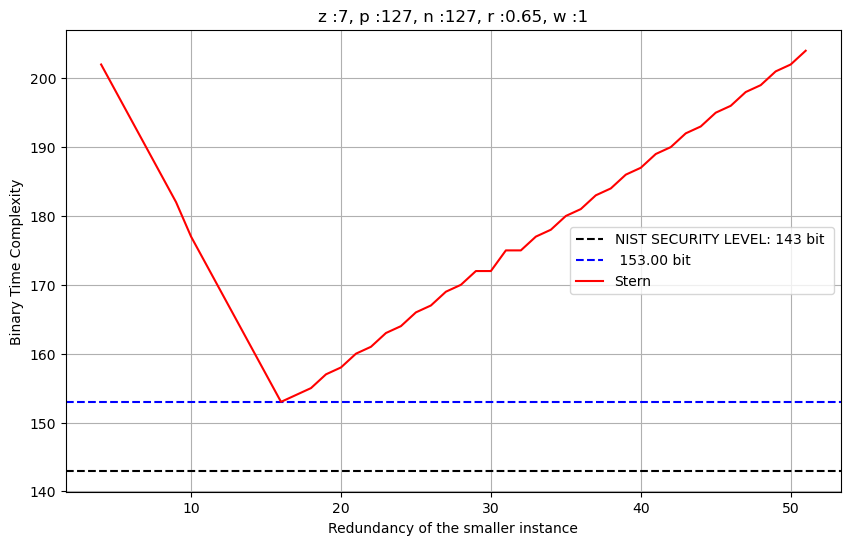

In [131]:
plot_overall_costs_stern("l", "7", 127, 0.65, 1, "127")


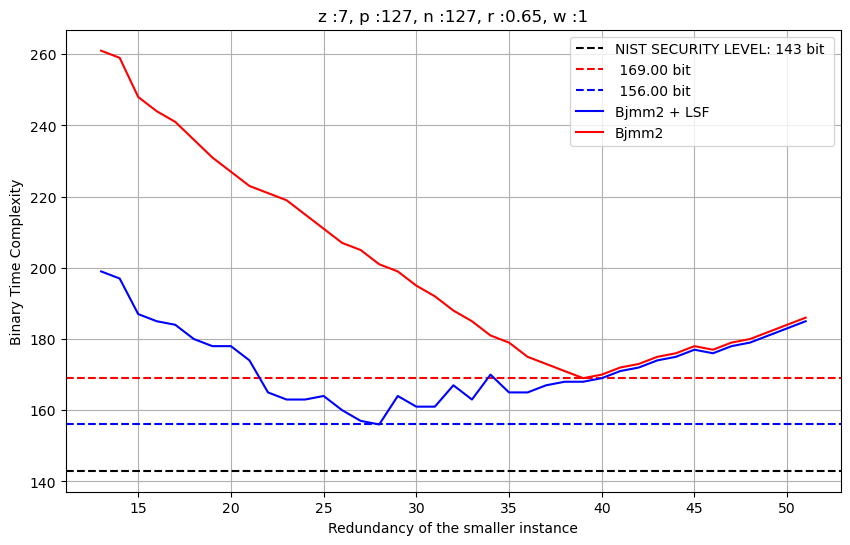

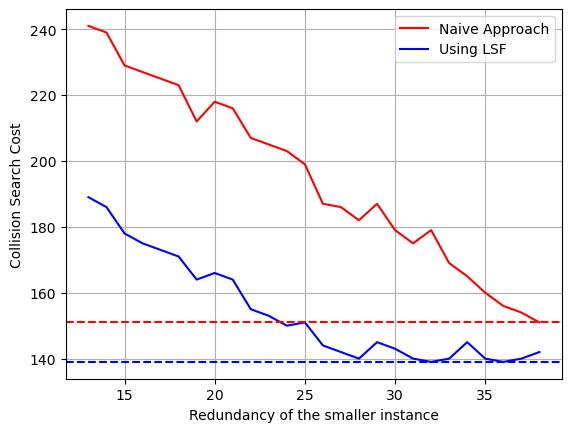

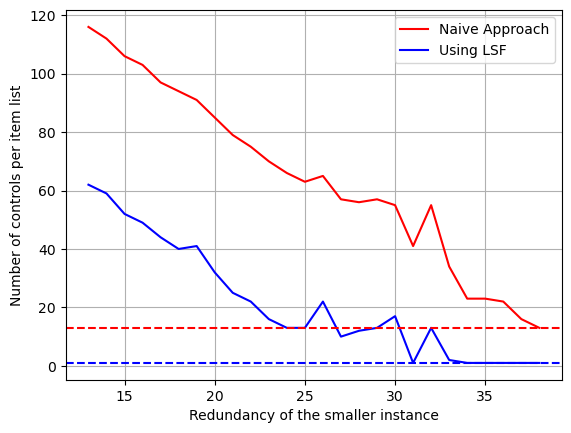

In [132]:
plot_overall_costs_bjmm("l", "2", "EuD", "7", 127, 0.65, 1, "127")
lsh_vs_naive("l", "2", "EuD", "7", "127")      

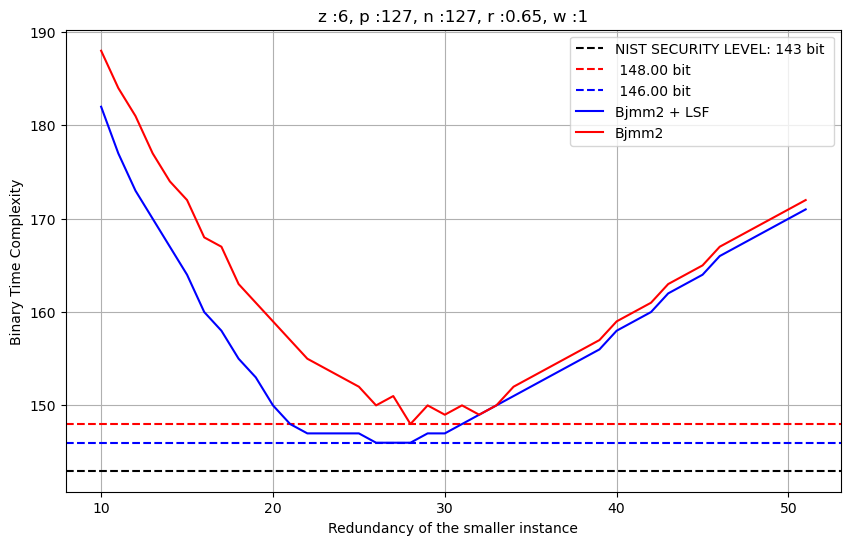

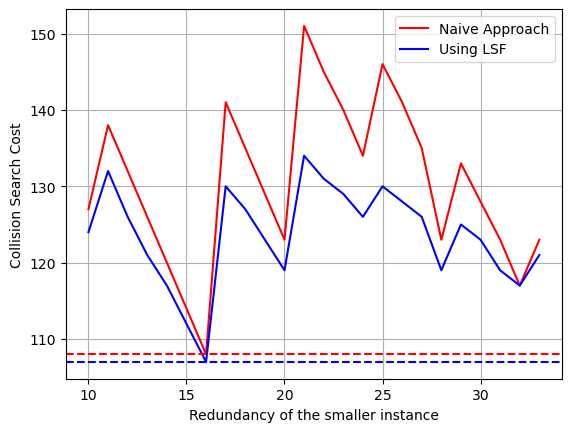

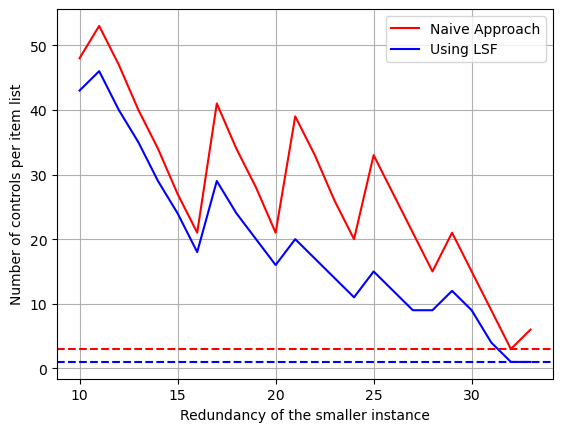

In [133]:
plot_overall_costs_bjmm("l", "2", "shifted_EuD", "6", 127, 0.65, 1, "127")
lsh_vs_naive("l", "2", "shifted_EuD", "6", "127")